In [1]:
%matplotlib inline

import numpy as np
import gymnasium as gym
import random
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
import math
import torchvision.transforms as T

## Set up display

In [2]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

## Deep Q-Network

In [3]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
        self.fc1 = nn.Linear(in_features=img_height * img_width * 3, out_features=24)
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)
        
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

## Experience class

In [4]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

In [5]:
e = Experience (2,3,1,4)
e

Experience(state=2, action=3, next_state=1, reward=4)

## Replay Memory

In [6]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

## Epsilon greedy strategy

In [7]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)

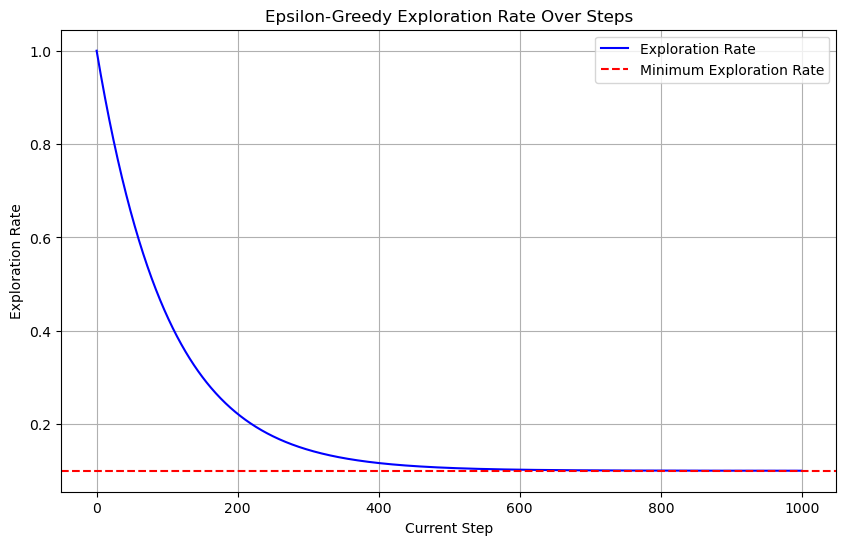

In [8]:
start = 1.0  # Starting exploration rate
end = 0.1    # Minimum exploration rate
decay = 0.01 # Decay rate

strategy = EpsilonGreedyStrategy(start, end, decay)

steps = range(0, 1000)  # Current steps from 0 to 999
exploration_rates = [strategy.get_exploration_rate(step) for step in steps]

plt.figure(figsize=(10, 6))
plt.plot(steps, exploration_rates, label='Exploration Rate', color='blue')
plt.title('Epsilon-Greedy Exploration Rate Over Steps')
plt.xlabel('Current Step')
plt.ylabel('Exploration Rate')
plt.axhline(y=end, color='red', linestyle='--', label='Minimum Exploration Rate')
plt.legend()
plt.grid()
plt.show()

## Reinforcement Learning Agent

In [9]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device

    def select_action(self, state, policy_network):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            return torch.tensor([random.randrange(self.num_actions)]).to(device) # explore
        else:
            with torch.no_grad(): # We only infer, not train
                return policy_network(state).argmax(dim=1).to(device) # exploit

## Environment Manager

In [10]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0', render_mode='rgb_array').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False

    def reset(self):
        self.env.reset()
        self.current_screen = None

    def close(self):
        self.env.close()

    def render(self):
        return self.env.render()

    def num_actions_available(self):
        return self.env.action_space.n

    def take_action(self, action):
        _, reward, self.done, _, _ = self.env.step(action.item())
        return torch.tensor([reward], device = self.device)

    def just_starting(self):
        return self.current_screen is None

    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1

    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]

    def get_processed_screen(self):
        screen = self.render().transpose((2, 0, 1)) # channel, height, width
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)

    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen

    def transform_screen_data(self, screen):
        # Packed in memory
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)

        resize = T.Compose([
            T.ToPILImage(),
            T.Resize((40,90)),
            T.ToTensor()
        ])

        # unsqueeze to add extra dimension as a batch dimension as
        # we are going to process screens in batches
        return resize(screen).unsqueeze(0).to(self.device)
        

/home/lauri/.conda/envs/rl/lib/python3.12/site-packages/gymnasium/envs/registration.py:523: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


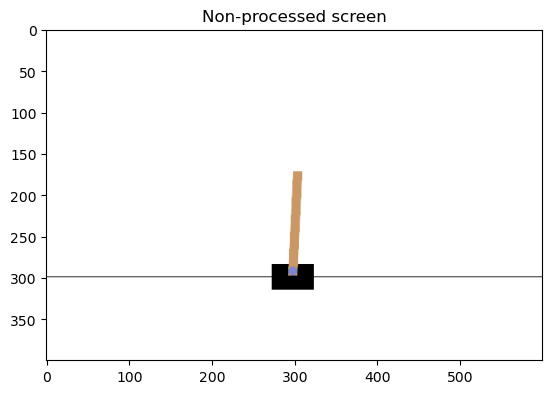

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
em = CartPoleEnvManager(device)
em.reset()
screen = em.render()

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen')
plt.show()

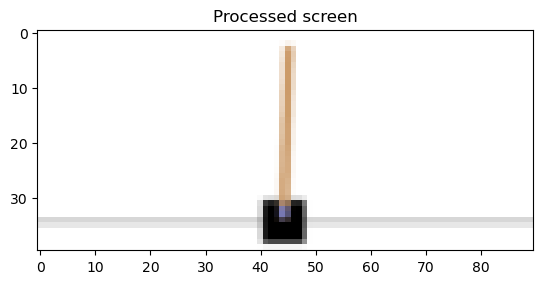

In [12]:
screen = em.get_processed_screen()

plt.imshow(screen.cpu().squeeze(0).permute(1,2,0), interpolation='none')
plt.title('Processed screen')
plt.show()

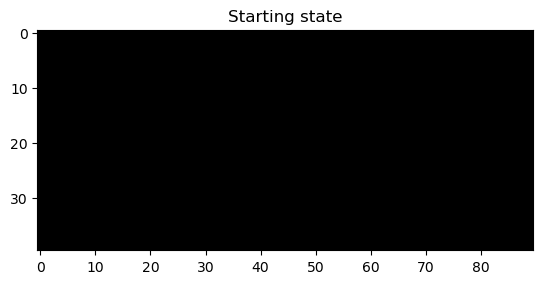

In [13]:
screen = em.get_state()
plt.imshow(screen.cpu().squeeze(0).permute(1,2,0), interpolation='none')
plt.title('Starting state')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5411765..0.6901961].


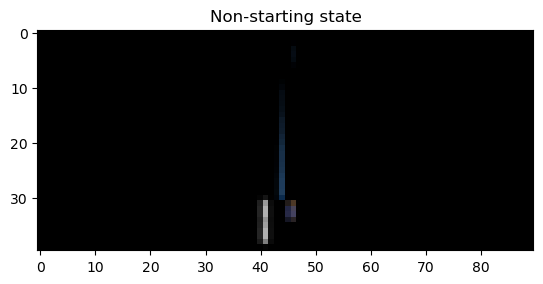

In [14]:
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()

plt.imshow(screen.cpu().squeeze(0).permute(1,2,0), interpolation='none')
plt.title('Non-starting state')
plt.show()

Diff between the last two images: most of the pixels are zero because not much has changed.

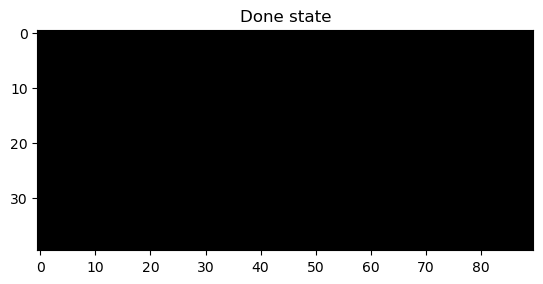

In [15]:
em.done = True
screen = em.get_state()

plt.imshow(screen.cpu().squeeze(0).permute(1,2,0), interpolation='none')
plt.title('Done state')
plt.show()
em.close()

## Utilities

In [16]:
# Plot duration of episode and 100-epsidoe moving averages
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    moving_avg = get_moving_avg(moving_avg_period, values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode", len(values), "\n", moving_avg_period, "episodes moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

def get_moving_avg(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        # unfold to get all the slices equal to size of a period
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

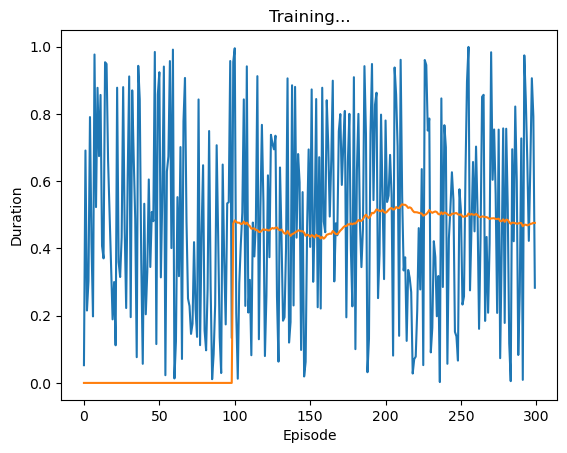

Episode 300 
 100 episodes moving avg: 0.4759098


In [17]:
plot(np.random.rand(300), 100)

## Main program

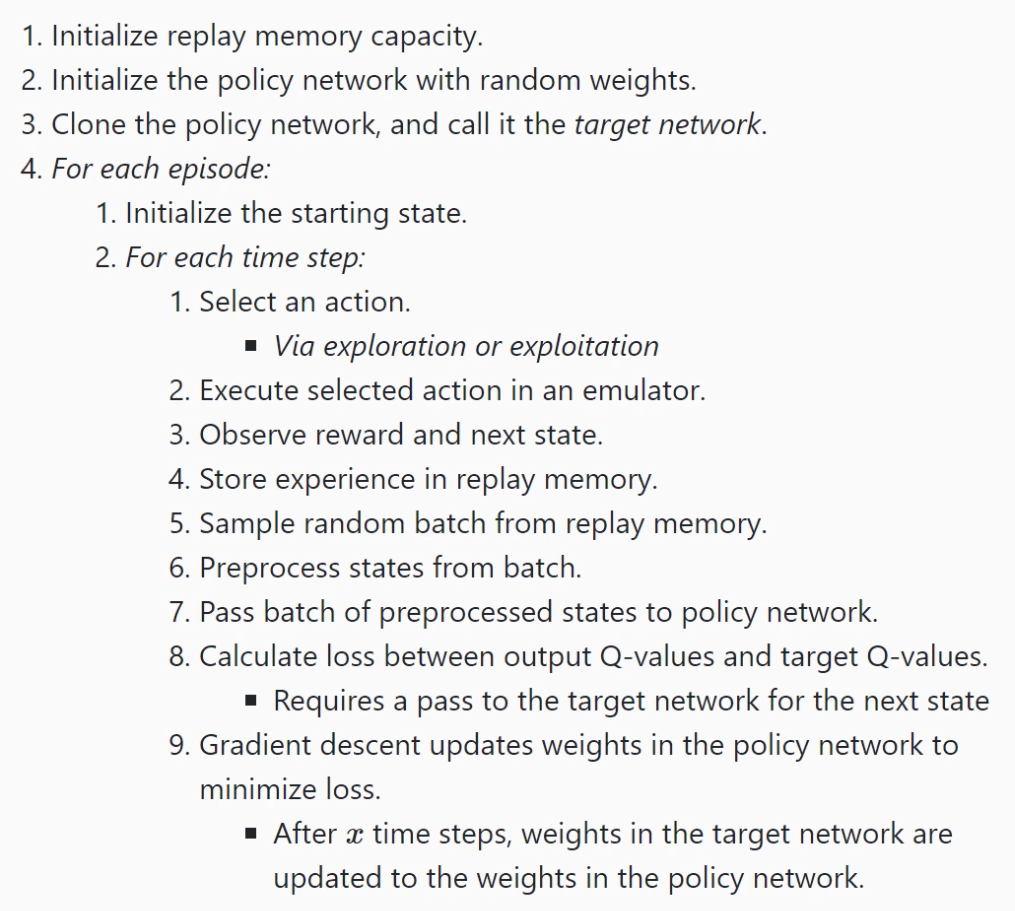

In [45]:
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action, dim=0)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    return (t1,t2,t3,t4)

In [19]:
e1 = Experience(1,1,1,1)
e2 = Experience(2,2,2,2)
e3 = Experience(3,3,3,3)

experiences = [e1,e2,e3]
experiences

[Experience(state=1, action=1, next_state=1, reward=1),
 Experience(state=2, action=2, next_state=2, reward=2),
 Experience(state=3, action=3, next_state=3, reward=3)]

In [20]:
list(zip(*experiences))

[(1, 2, 3), (1, 2, 3), (1, 2, 3), (1, 2, 3)]

In [21]:
batch = Experience(*zip(*experiences))
batch

Experience(state=(1, 2, 3), action=(1, 2, 3), next_state=(1, 2, 3), reward=(1, 2, 3))

In [22]:
t = torch.tensor([1,2,3,4])
t

tensor([1, 2, 3, 4])

In [23]:
t.unsqueeze(0)

tensor([[1, 2, 3, 4]])

In [24]:
t.unsqueeze(1)

tensor([[1],
        [2],
        [3],
        [4]])

In [25]:
# Create a 2D tensor (e.g., Q-values for 3 states and 2 actions)
q_values = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
print("Q-values:\n", q_values)

# Create an index tensor for actions taken
actions = torch.tensor([0, 1, 0])  # Indices of actions taken for each state

# Gather the Q-values for the actions taken
gathered_values = q_values.gather(dim=1, index=actions.unsqueeze(-1))
print("Gathered values:\n", gathered_values)

Q-values:
 tensor([[1., 2.],
        [3., 4.],
        [5., 6.]])
Gathered values:
 tensor([[1.],
        [4.],
        [5.]])


In [44]:
class QValues():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    # Get the maximum Q-value predicted by the target net among all possible next actions
    @staticmethod
    def get_next(target_net, next_states):
        """
        For example, if next_states has a shape of (N, C, H, W)
        (where N is the batch size, C is the number of channels, and H and W are height and width),
        after flattening, it will have a shape of (N, C*H*W).

        The max function is called on the flattened tensor along dimension 1.
        [0] contains the value, [1] is the index

        The eq(0) method checks if the maximum values obtained in the previous step are equal to zero.

        Ensure that the final tensor is boolean type by calling .type(torch.bool).

        Final state = black screen = all pixels are black = max value must be 0.
        Q-value for final state is always 0 as no actions can be taken.
        """
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)

        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        # Now all final states have zero, so update only non final state indices
        # Get the max predicted q-values for the non final states
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

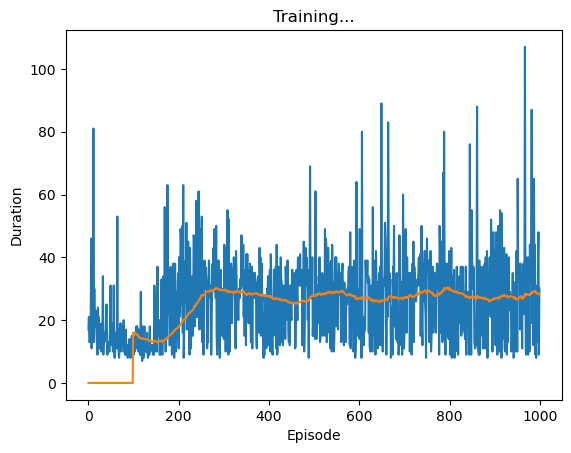

Episode 1000 
 100 episodes moving avg: 28.23


In [47]:
batch_size = 256
gamma = 0.999

# Epsilon
eps_start =1
eps_end = 0.01
eps_decay = 0.001

target_update = 10 # episodes
memory_size = 100000 # capacity of replay memory
lr = 0.001
num_episodes = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() # Not training mode, only for inference
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()

    for timestep in range(1000):
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state

        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad() # Set the gradients of all weights and biases to zero, otherwise we accumulate the gradients of all backprop runs
            loss.backward() # Torch accumulates all the gradients during backdrop
            optimizer.step()

        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

In [52]:
torch.tensor([[5,2],[3,4]]).max(dim=1)[0]

tensor([5, 4])